In [128]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [129]:
def parse_out(file_path: str):
    # regex for the metrics line
    pattern = re.compile(
        r"Val NLL (?P<val_nll>[\d\.\-]+)\s*--\s*"
        r"Val Atom type KL: (?P<val_atom_kl>[\d\.\-]+)\s*--\s*"
        r"Val Edge type KL: (?P<val_edge_kl>[\d\.\-]+)\s*--\s*"
        r"Val Edge type logp: (?P<val_edge_logp>[\d\.\-]+)\s*--\s*"
        r"Val Edge type CE: (?P<val_edge_ce>[\d\.\-]+)"
    )

    # regex for the best val line
    best_pattern = re.compile(
        r"Val NLL: (?P<val_nll_detail>[\d\.]+)\s*Best Val NLL:\s*(?P<best_val_nll>[\d\.]+)"
    )

    records = []

    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            match = pattern.search(line)
            if match:
                metrics = match.groupdict()
            else:
                continue

            # check for the "Val NLL: ... Best Val NLL: ..." on same line
            best_match = best_pattern.search(line)
            if best_match:
                metrics.update(best_match.groupdict())

            records.append(metrics)

    # put into dataframe
    df = pd.DataFrame(records)
    df = df.apply(pd.to_numeric, errors="ignore")
    return df

In [ ]:
experiments = {
    'Experiment 1': 'expr1.out',
    'Experiment 2': 'expr2.out',
    'Experiment 3': 'expr3.out'
}
dfs = []
for expr_name, file_name in experiments.items():
    file_path = 'data/' + file_name
    print(file_path)
    dfs.append(parse_out(file_path))

../data/expr1.out
../data/expr2.out
../data/expr3.out


In [131]:
fs=9
plt.rcParams.update({'font.size': fs})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']

In [132]:
colors = ['#89bebf',  # muted teal / soft cyan: ATMOMACCS v4
          '#949494',  # light gray '#89bebf': TopFP
          '#f5bad3',   # soft pink / baby pink: ATMO 
          '#e1aee4',  # pastel pink-purple / light orchid: ATMOMACCS v1
          '#bdabbf',  # muted lavender / dusty lilac: ATMOMACCS v2
          "#282f2f",  # light aqua / pale cyan: : ATMOMACCS v3
          '#89bebf',  # muted teal / soft cyan: ATMOMACCS v4
          '#8995BF'  # desaturated periwinkle / dusty indigo: : ATMOMACCS v5
         ]

C:\Users\kuuli\AppData\Local\Temp\ipykernel_17520\1336950327.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


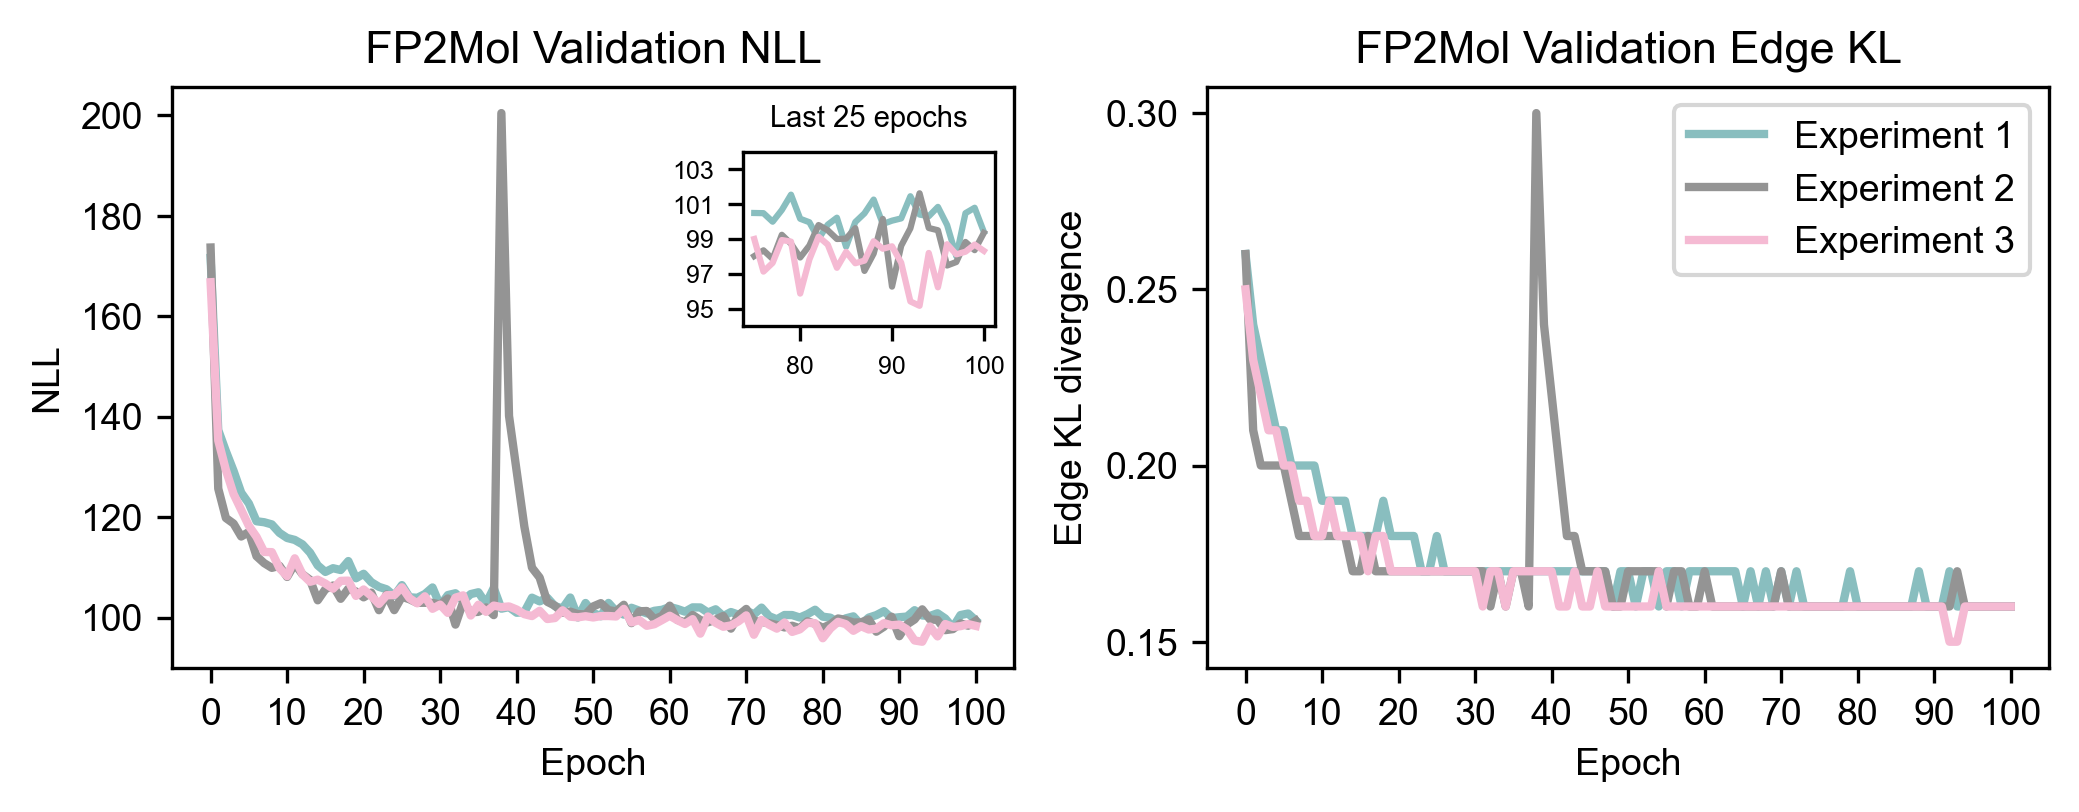

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(504/72, 200/72), sharex=True, dpi=300)

labels = experiments.keys()

for df, label, color in zip(dfs, labels, colors):
    x = df.index.values
    axes[0].plot(x, df['val_nll'].values, label=label, color=color, lw=2)
    axes[1].plot(x, df['val_edge_kl'].values, label=label, color=color, lw=2)

axes[0].set_title("FP2Mol Validation NLL")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("NLL")
axes[0].set_xticks(np.linspace(0, 100, 11))

axes[1].set_title("FP2Mol Validation Edge KL")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Edge KL divergence")
axes[1].set_xticks(np.linspace(0, 100, 11))
axes[1].set_yticks(np.linspace(0.15, 0.3, 4))

axes[1].legend()

# --- inset zoom of last 15 epochs ---
ax_inset = inset_axes(axes[0], width="30%", height="30%", loc="upper right",
                      bbox_to_anchor=(-0.0, -0.08, 1.0, 1.0),  # x0, y0, width, height
                      bbox_transform=axes[0].transAxes)

for df, label, color in zip(dfs, labels, colors):
    x = df.index.values
    y = df['val_nll'].values
    mask = x >= (x.max() - 25)
    ax_inset.plot(x[mask], y[mask], color=color, lw=1.5)
    ax_inset.set_yticks([95, 97, 99, 101, 103])
    ax_inset.set_ylim([94,104])

ax_inset.set_title("Last 25 epochs", fontsize=fs-2)
ax_inset.tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.savefig("figs/fp2mol_nll_edge_kl.png", dpi=300)
plt.show()

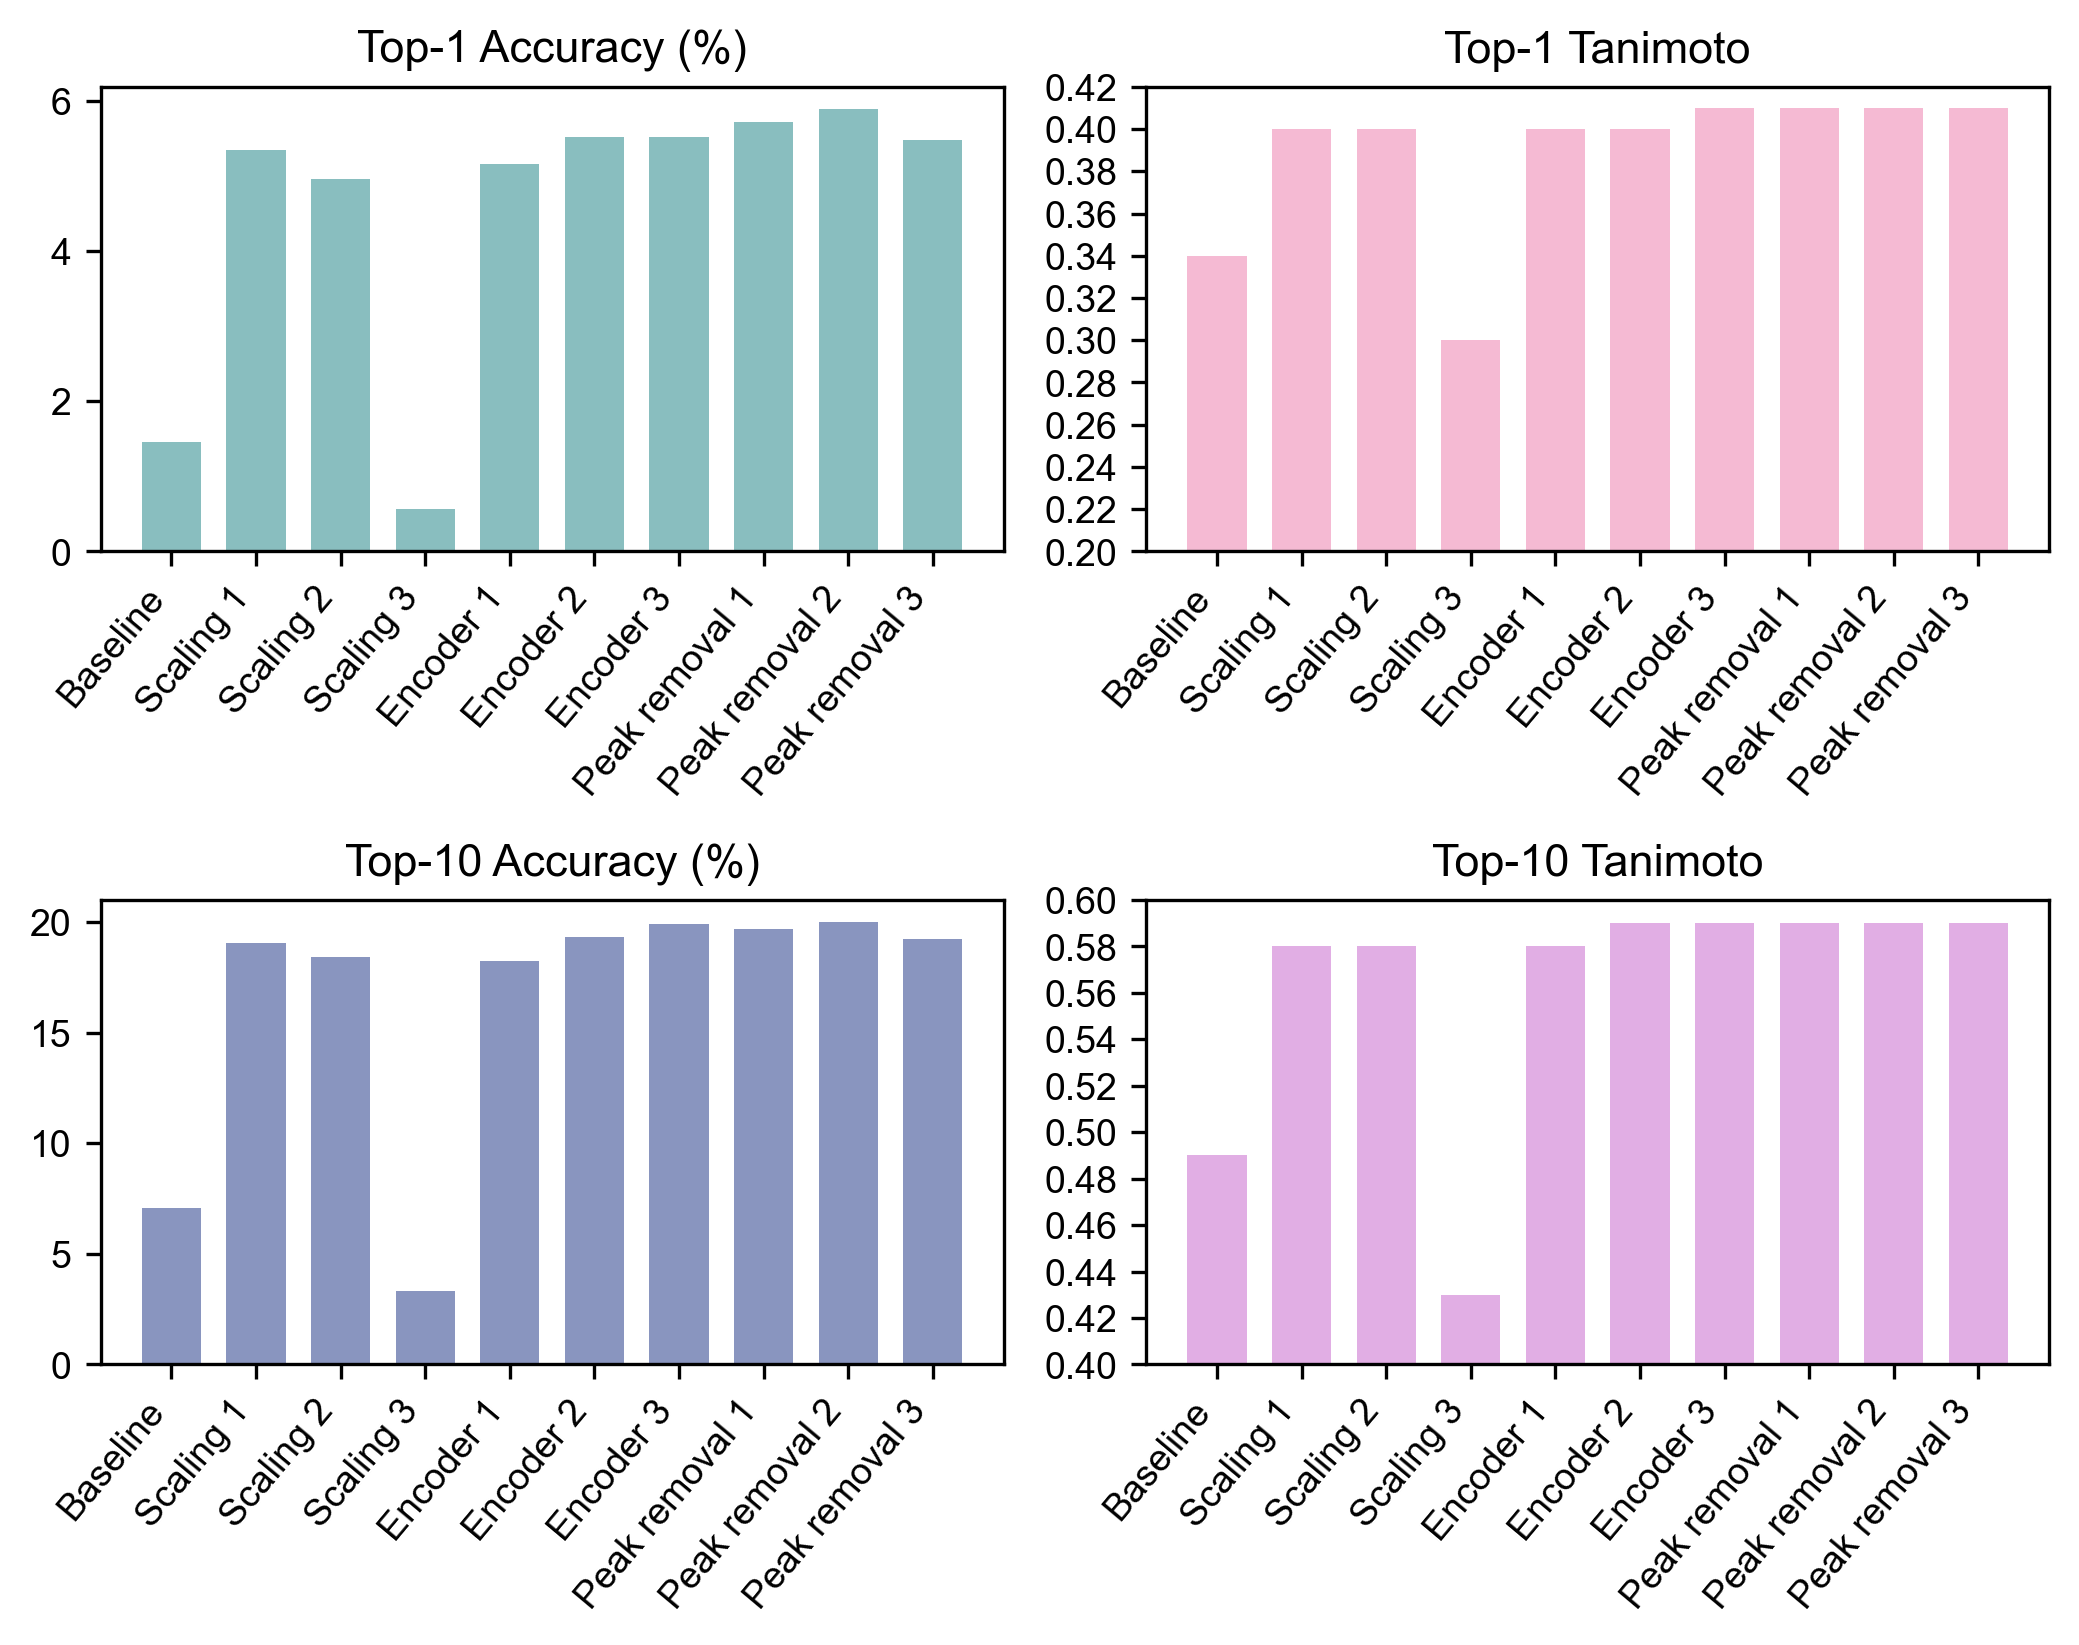

In [134]:
# Example: converting your table into a DataFrame
data = {
    "Experiment": [
        "Baseline", "Scaling 1", "Scaling 2", "Scaling 3",
        "Encoder 1", "Encoder 2", "Encoder 3",
        "Peak removal 1", "Peak removal 2", "Peak removal 3"
    ],
    "Top-1 Accuracy": [1.46, 5.35, 4.96, 0.57, 5.16, 5.52, 5.51, 5.71, 5.89, 5.47],
    "Top-1 Tanimoto": [0.34, 0.40, 0.40, 0.30, 0.40, 0.40, 0.41, 0.41, 0.41, 0.41],
    "Top-10 Accuracy": [7.08, 19.07, 18.4, 3.33, 18.22, 19.33, 19.89, 19.7, 20.0, 19.24],
    "Top-10 Tanimoto": [0.49, 0.58, 0.58, 0.43, 0.58, 0.59, 0.59, 0.59, 0.59, 0.59],
    "Validity": [93.44, 95.17, 95.12, 96.30, 95.48, 95.28, 95.17, 95.03, 95.11, 95.20]
}

colors = ['#89bebf',  # muted teal / soft cyan: ATMOMACCS v4
          '#949494',  # light gray '#89bebf': TopFP
          '#f5bad3',   # soft pink / baby pink: ATMO 
          '#e1aee4',  # pastel pink-purple / light orchid: ATMOMACCS v1
          '#bdabbf',  # muted lavender / dusty lilac: ATMOMACCS v2
          "#282f2f",  # light aqua / pale cyan: : ATMOMACCS v3
          '#89bebf',  # muted teal / soft cyan: ATMOMACCS v4
          '#8995BF'  # desaturated periwinkle / dusty indigo: : ATMOMACCS v5
         ]

df = pd.DataFrame(data)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(504/72, 200/72*2), dpi =300)

x = np.arange(len(df))  # positions
width = 0.7
rot_amt = 50

# Top-1 Accuracy
axes[0,0].bar(x, df["Top-1 Accuracy"], width, color='#89bebf')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(df["Experiment"], rotation=rot_amt, ha='right')
axes[0,0].set_title("Top-1 Accuracy (%)")

# Top-1 Tanimoto
axes[0,1].bar(x, df["Top-1 Tanimoto"], width, color='#f5bad3')
axes[0,1].set_xticks(x)
axes[0,1].set_ylim([0.2,0.42])
axes[0,1].set_yticks(np.linspace(0.2, 0.42, 12))
axes[0,1].set_xticklabels(df["Experiment"], rotation=rot_amt, ha='right')
axes[0,1].set_title("Top-1 Tanimoto")

# Top-10 Accuracy
axes[1,0].bar(x, df["Top-10 Accuracy"], width, color='#8995BF')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(df["Experiment"], rotation=rot_amt, ha='right')
axes[1,0].set_title("Top-10 Accuracy (%)")

# Top-10 Tanimoto
axes[1,1].bar(x, df["Top-10 Tanimoto"], width, color='#e1aee4')
axes[1,1].set_xticks(x)
axes[1,1].set_ylim([0.4,0.6])
axes[1,1].set_xticklabels(df["Experiment"], rotation=rot_amt, ha='right')
axes[1,1].set_yticks(np.linspace(0.4, 0.6, 11))
axes[1,1].set_title("Top-10 Tanimoto")

plt.tight_layout()
plt.show()


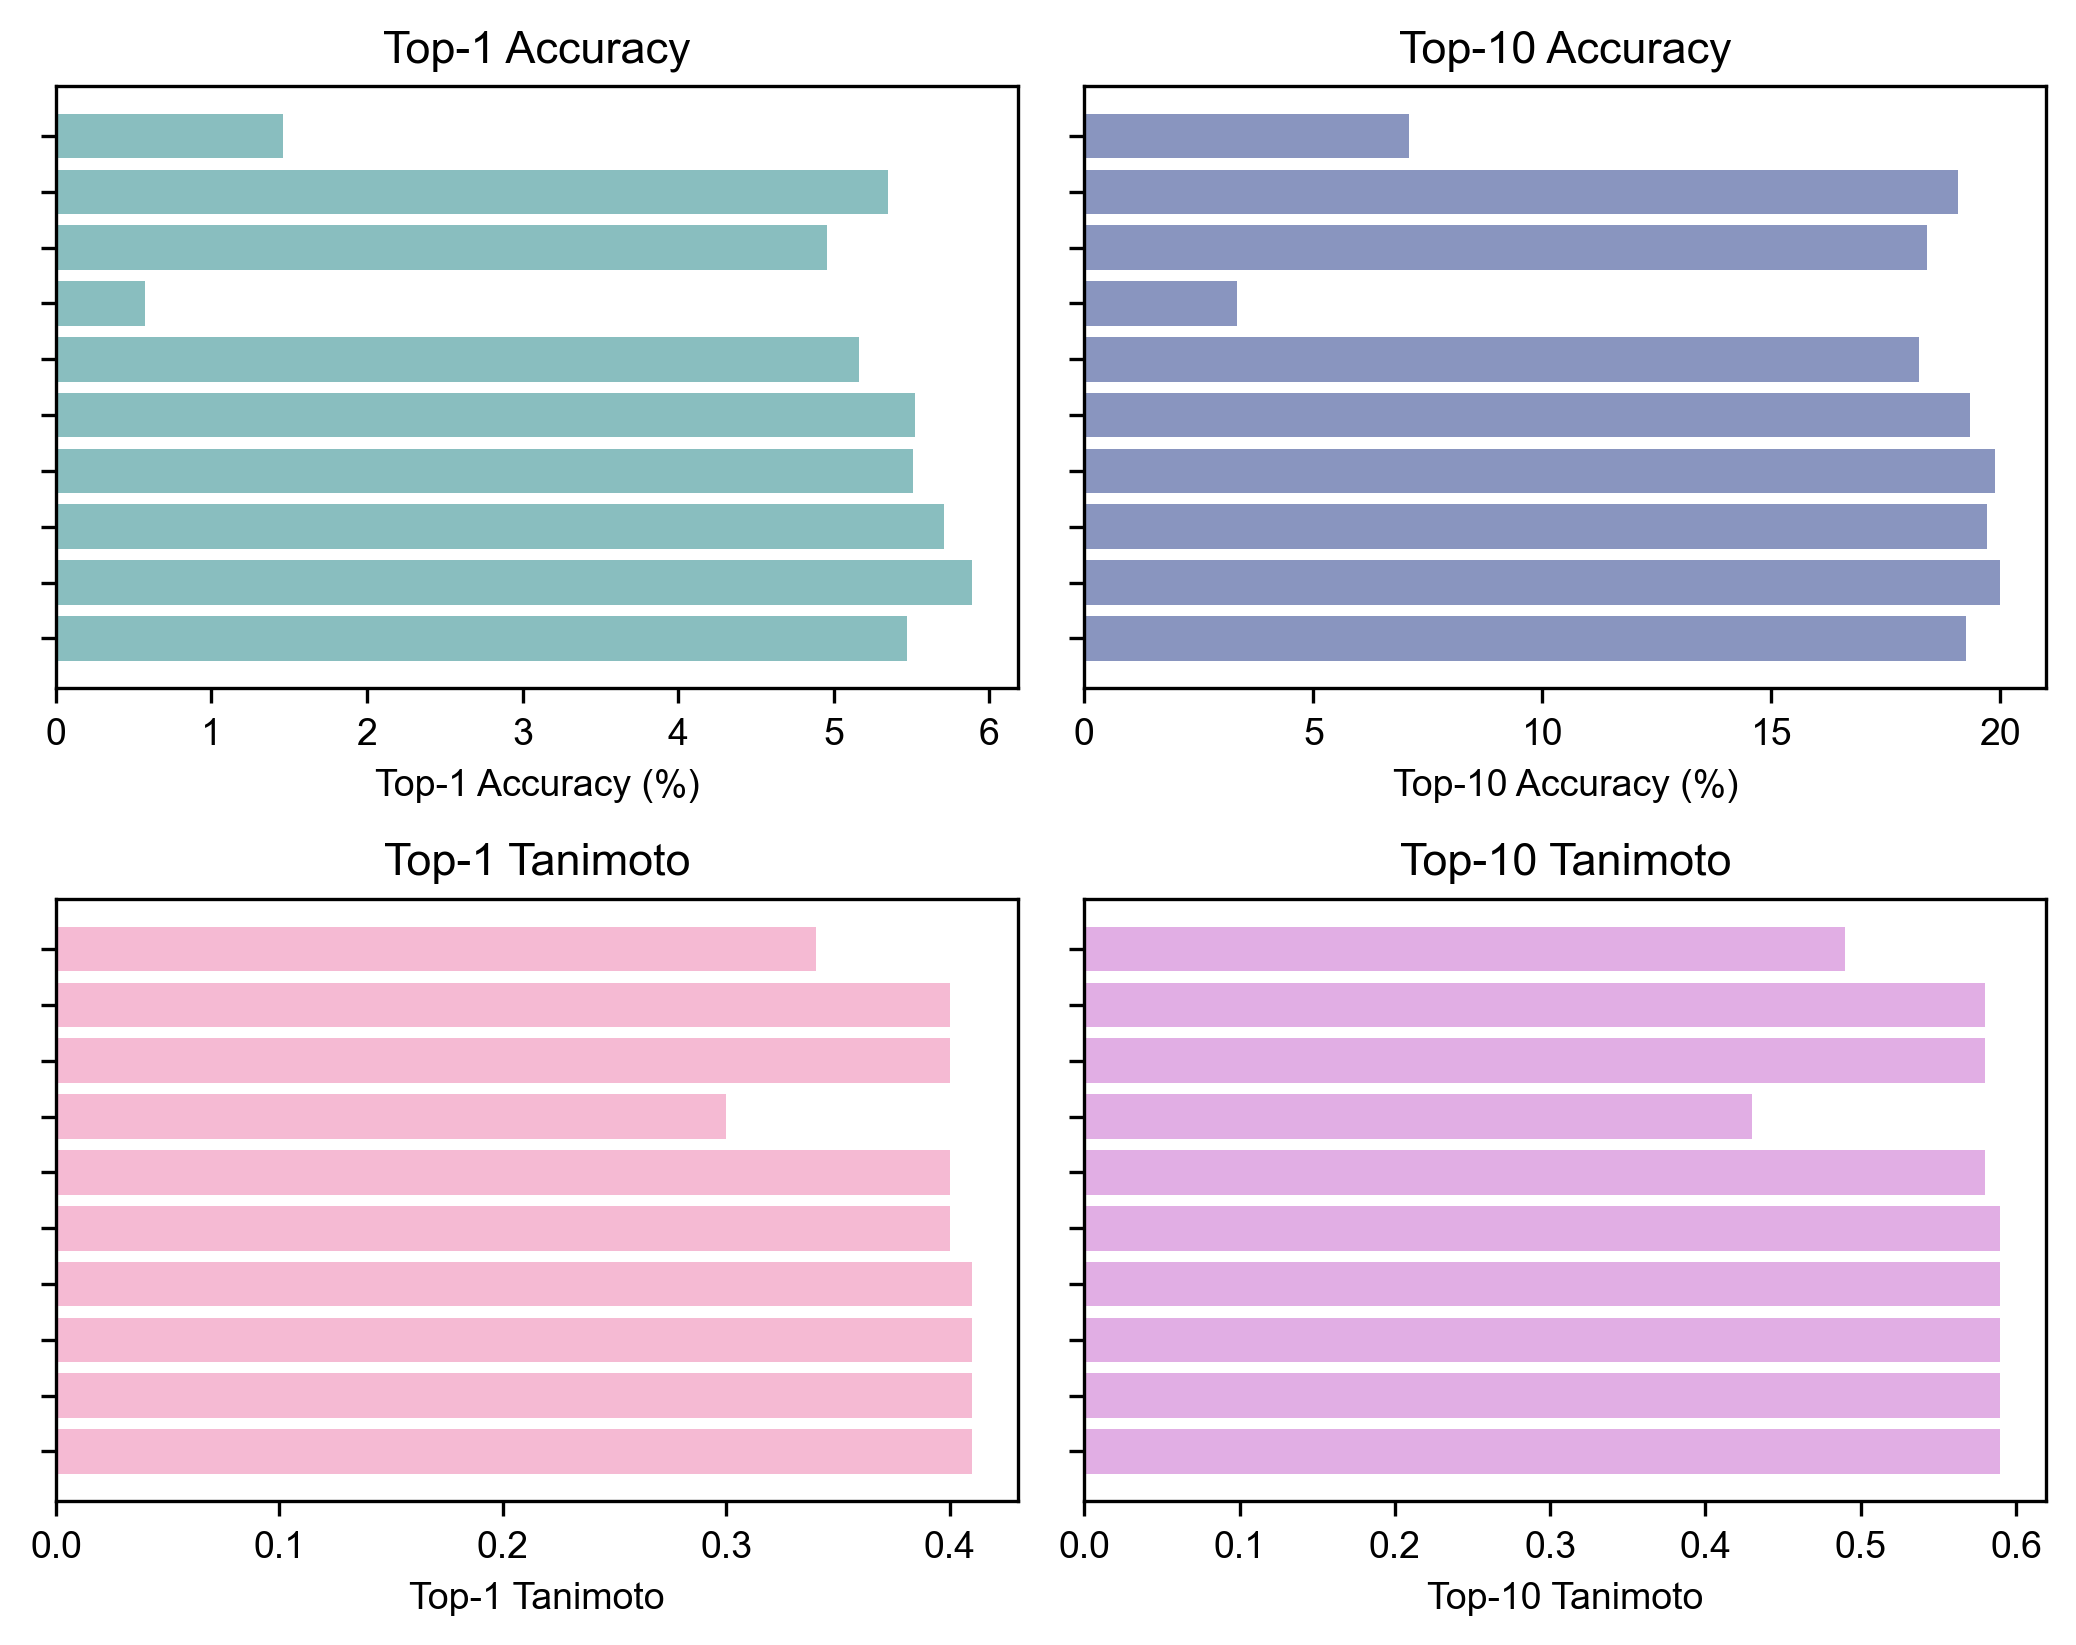

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    "Experiment": [
        "Baseline", "Scaling 1", "Scaling 2", "Scaling 3",
        "Encoder 1", "Encoder 2", "Encoder 3",
        "Peak removal 1", "Peak removal 2", "Peak removal 3"
    ],
    "Top-1 Accuracy": [1.46, 5.35, 4.96, 0.57, 5.16, 5.52, 5.51, 5.71, 5.89, 5.47],
    "Top-1 Tanimoto": [0.34, 0.40, 0.40, 0.30, 0.40, 0.40, 0.41, 0.41, 0.41, 0.41],
    "Top-10 Accuracy": [7.08, 19.07, 18.4, 3.33, 18.22, 19.33, 19.89, 19.7, 20.0, 19.24],
    "Top-10 Tanimoto": [0.49, 0.58, 0.58, 0.43, 0.58, 0.59, 0.59, 0.59, 0.59, 0.59]
}

df = pd.DataFrame(data)
experiments = df["Experiment"].values
y_pos = np.arange(len(experiments))

# Colors for each plot
colors = ['#89bebf', '#8995BF', '#f5bad3', '#e1aee4']

# Figure
fig, axes = plt.subplots(2, 2, figsize=(504/72, 200/72*2), dpi=300, sharey=True)

# Top-1 Accuracy
axes[0,0].barh(y_pos, df["Top-1 Accuracy"], color=colors[0])
axes[0,0].set_yticks(y_pos)
axes[0,0].set_yticklabels(experiments)
axes[0,0].set_xlabel("Top-1 Accuracy (%)")
axes[0,0].set_title("Top-1 Accuracy")

# Top-10 Accuracy
axes[0,1].barh(y_pos, df["Top-10 Accuracy"], color=colors[1])
axes[0,1].set_yticks(y_pos)
axes[0,1].set_yticklabels([])  # hide yticklabels on the right
axes[0,1].set_xlabel("Top-10 Accuracy (%)")
axes[0,1].set_title("Top-10 Accuracy")

# Top-1 Tanimoto
axes[1,0].barh(y_pos, df["Top-1 Tanimoto"], color=colors[2])
axes[1,0].set_yticks(y_pos)
axes[1,0].set_yticklabels(experiments)
axes[1,0].set_xlabel("Top-1 Tanimoto")
axes[1,0].set_title("Top-1 Tanimoto")

# Top-10 Tanimoto
axes[1,1].barh(y_pos, df["Top-10 Tanimoto"], color=colors[3])
axes[1,1].set_yticks(y_pos)
axes[1,1].set_yticklabels([])  # hide yticklabels on the right
axes[1,1].set_xlabel("Top-10 Tanimoto")
axes[1,1].set_title("Top-10 Tanimoto")
axes[1,1].invert_yaxis()

plt.tight_layout()
plt.show()


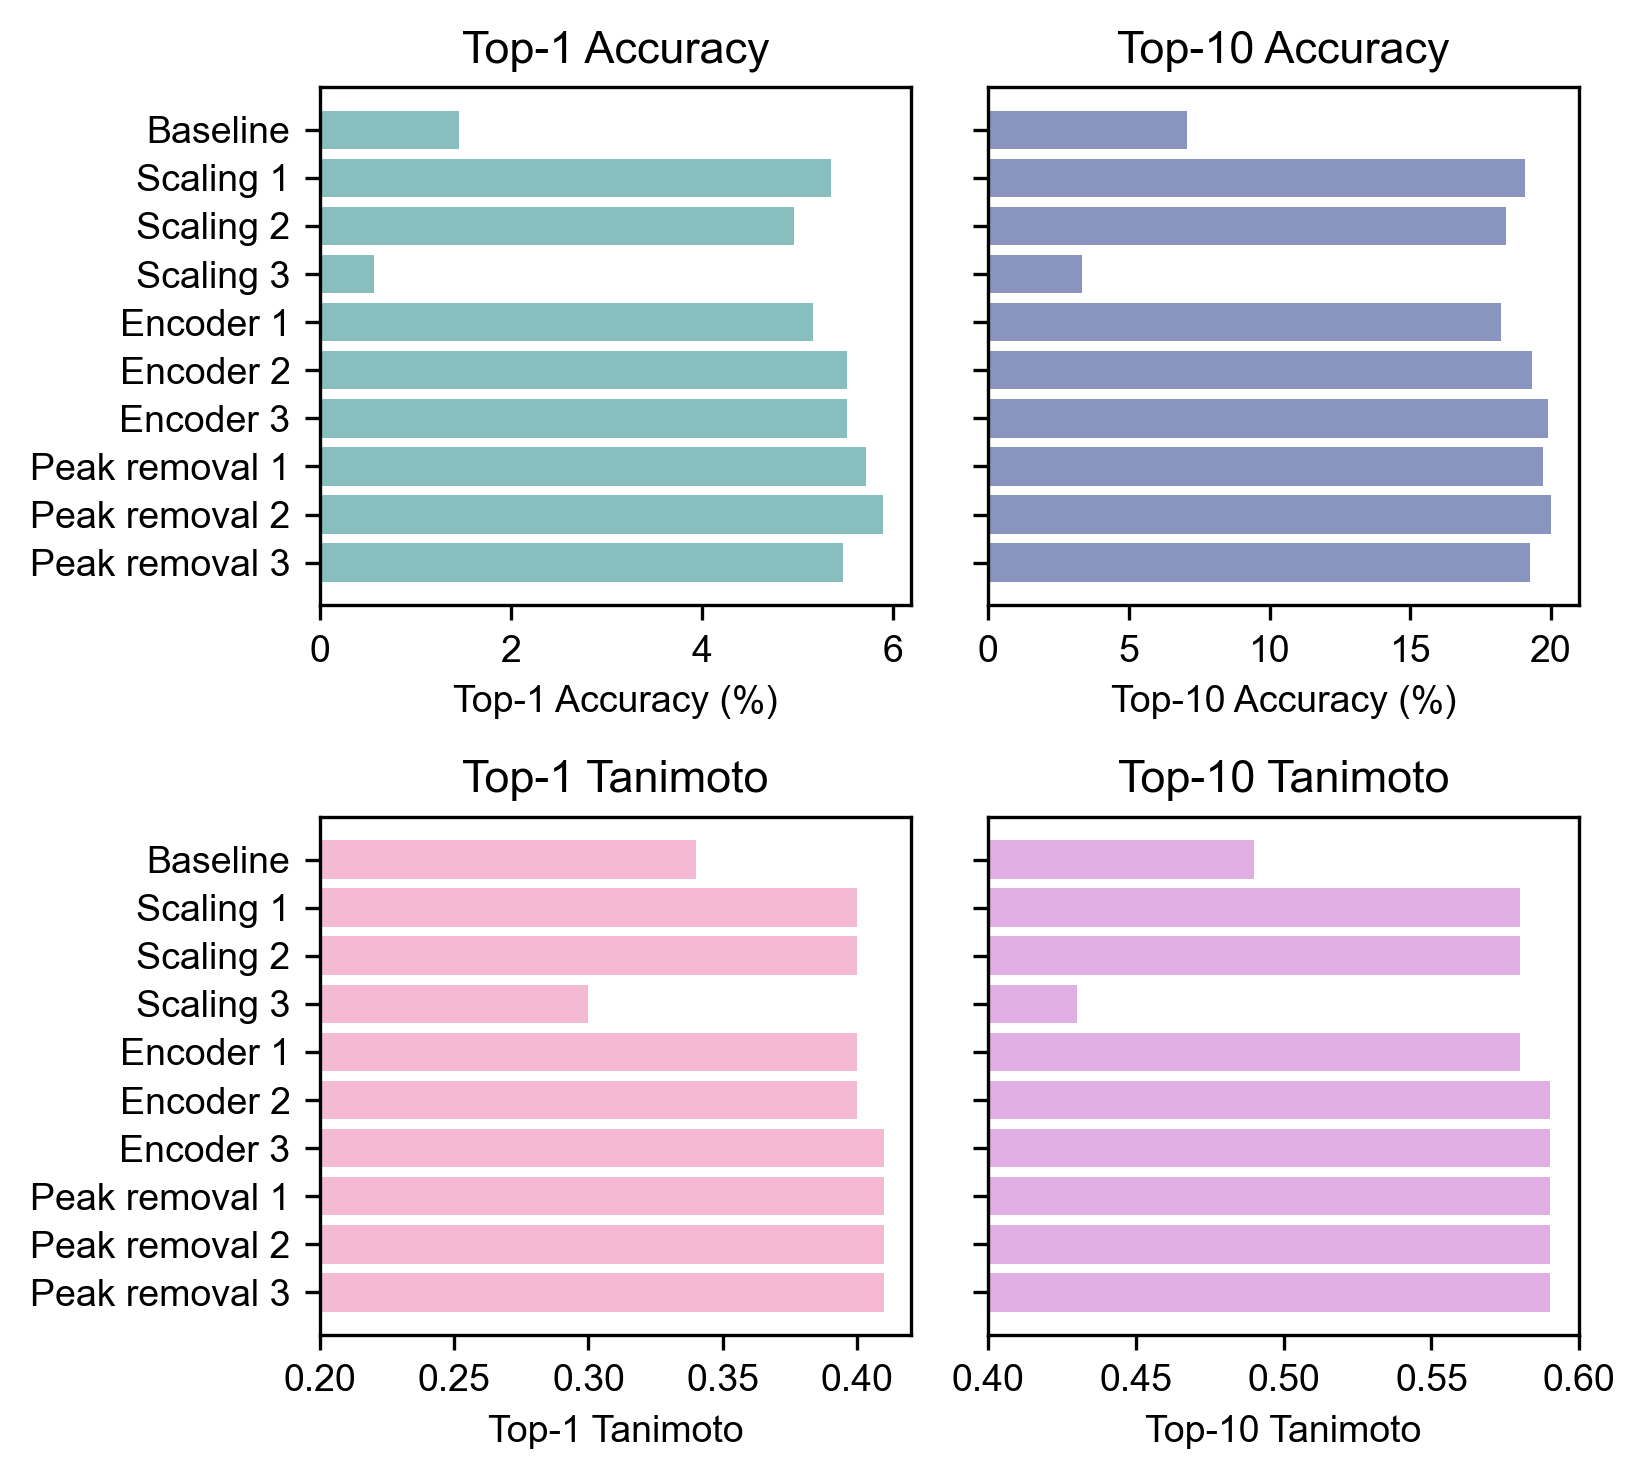

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    "Experiment": [
        "Baseline", "Scaling 1", "Scaling 2", "Scaling 3",
        "Encoder 1", "Encoder 2", "Encoder 3",
        "Peak removal 1", "Peak removal 2", "Peak removal 3"
    ],
    "Top-1 Accuracy": [1.46, 5.35, 4.96, 0.57, 5.16, 5.52, 5.51, 5.71, 5.89, 5.47],
    "Top-1 Tanimoto": [0.34, 0.40, 0.40, 0.30, 0.40, 0.40, 0.41, 0.41, 0.41, 0.41],
    "Top-10 Accuracy": [7.08, 19.07, 18.4, 3.33, 18.22, 19.33, 19.89, 19.7, 20.0, 19.24],
    "Top-10 Tanimoto": [0.49, 0.58, 0.58, 0.43, 0.58, 0.59, 0.59, 0.59, 0.59, 0.59]
}

df = pd.DataFrame(data)
experiments = df["Experiment"].values
y_pos = np.arange(len(experiments))

# Colors
colors = ['#89bebf', '#8995BF', '#f5bad3', '#e1aee4']

# Figure
fig, axes = plt.subplots(2, 2, figsize=(400/72, 180/72*2), dpi=300, sharey=True)

# Top-1 Accuracy
axes[0,0].barh(y_pos, df["Top-1 Accuracy"], color=colors[0])
axes[0,0].set_yticks(y_pos)
axes[0,0].set_yticklabels(experiments)
axes[0,0].set_xlabel("Top-1 Accuracy (%)")
axes[0,0].set_title("Top-1 Accuracy")
axes[0,0].set_xlim([0,6])
axes[0,0].set_xticks(np.linspace(0.2, 0.4, 5))

# Top-10 Accuracy
axes[0,1].barh(y_pos, df["Top-10 Accuracy"], color=colors[1])
axes[0,1].set_yticks(y_pos)
axes[0,1].set_xlabel("Top-10 Accuracy (%)")
axes[0,1].set_title("Top-10 Accuracy")

# Top-1 Tanimoto
axes[1,0].barh(y_pos, df["Top-1 Tanimoto"], color=colors[2])
axes[1,0].set_yticks(y_pos)
axes[1,0].set_yticklabels(experiments)
axes[1,0].set_xlabel("Top-1 Tanimoto")
axes[1,0].set_title("Top-1 Tanimoto")
axes[1,0].set_xlim([0.2,0.42])
axes[1,0].set_xticks(np.linspace(0.2, 0.4, 5))

# Top-10 Tanimoto
axes[1,1].barh(y_pos, df["Top-10 Tanimoto"], color=colors[3])
axes[1,1].set_yticks(y_pos)
axes[1,1].invert_yaxis()
axes[1,1].set_xlabel("Top-10 Tanimoto")
axes[1,1].set_title("Top-10 Tanimoto")
axes[1,1].set_xlim([0.4,0.6])
axes[1,1].set_xticks(np.linspace(0.4, 0.6, 5))

plt.tight_layout()
plt.show()


In [137]:
dfs[1].to_csv('df.csv')